In [1]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt
from image import draw_training_data, draw_bounding_boxes, generate_image, draw_bounding_boxes_from_tensor
from data import get_generator

In [2]:
generator = get_generator(image_size=(448, 448), batch_size=32)

# Sample training image

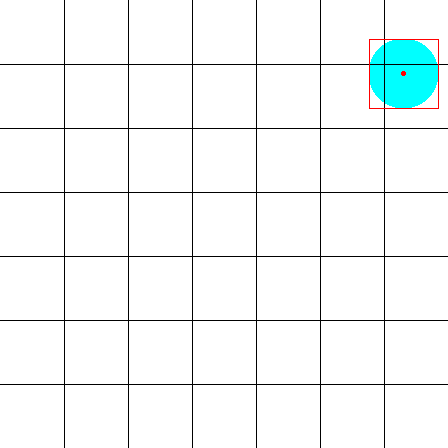

In [3]:
image, data = generate_image(image_size=(448, 448))
img = Image.fromarray(image)
draw_training_data(img, data)

# Draw generated images

In [ ]:
fig, axes = plt.subplots(8, 4, figsize=(12, 16))

batch = next(generator())

for index in range(32):
    axes[index//4, index%4].imshow(
        draw_bounding_boxes_from_tensor(batch[0][index] * 255., batch[1][index], num_boxes_per_cell=1)
    )
    
plt.show()

# Tiny/Fast Yolo Model

In [ ]:
NUM_CELLS = 7
NUM_BOXES_PER_CELL = 2
NUM_CLASSES = 3

In [ ]:
def Conv2D(filters, kernel_size, strides=1):
    return keras.layers.Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding='same',
        activation=keras.layers.LeakyReLU(.01)
    )

yolo_model = keras.Sequential()
yolo_model.add(Conv2D(16, 3))
yolo_model.add(keras.layers.BatchNormalization())
yolo_model.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
yolo_model.add(Conv2D(32, 3))
yolo_model.add(keras.layers.BatchNormalization())
yolo_model.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
yolo_model.add(Conv2D(64, 3))
yolo_model.add(keras.layers.BatchNormalization())
yolo_model.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
yolo_model.add(Conv2D(128, 3))
yolo_model.add(keras.layers.BatchNormalization())
yolo_model.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
yolo_model.add(Conv2D(256, 3))
yolo_model.add(keras.layers.BatchNormalization())
yolo_model.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
yolo_model.add(Conv2D(512, 3))
yolo_model.add(keras.layers.BatchNormalization())
yolo_model.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
yolo_model.add(Conv2D(1024, 3))
yolo_model.add(keras.layers.BatchNormalization())
yolo_model.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
yolo_model.add(Conv2D(256, 3))
yolo_model.add(keras.layers.BatchNormalization())
yolo_model.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
yolo_model.add(Conv2D(256, 3))
yolo_model.add(keras.layers.BatchNormalization())
yolo_model.add(Conv2D(256, 3))
yolo_model.add(keras.layers.BatchNormalization())
yolo_model.add(keras.layers.Flatten())
yolo_model.add(keras.layers.Dense(units=2048, activation=keras.layers.LeakyReLU(.01)))
yolo_model.add(keras.layers.BatchNormalization())
yolo_model.add(keras.layers.Dense(units=NUM_CELLS * NUM_CELLS * ((5 * NUM_BOXES_PER_CELL) + NUM_CLASSES), activation="sigmoid"))

# call once to check if everything works
batch = next(generator())
result = yolo_model(batch[0])

# Loss function

In [ ]:
class YoloLoss(tf.keras.losses.Loss):

    def config(self, image_size=(448, 448), num_cells=7, num_classes=3, num_boxes_per_cell=2, lambda_coord=5, lambda_noobj=.5):
        self.__image_size = image_size
        self.__num_cells = num_cells
        self.__num_grid_cells = num_cells * num_cells
        self.__num_classes = num_classes
        self.__num_boxes_per_cell = num_boxes_per_cell
        self.__lambda_coord = lambda_coord
        self.__lambda_noobj = lambda_noobj
 

    @tf.autograph.experimental.do_not_convert
    def call(self, y1, y2):                
        y_true = tf.reshape(y1, (-1, self.__num_boxes_per_cell, 5 + self.__num_classes))        
        y_pred = tf.reshape(y2, (-1, self.__num_boxes_per_cell, (self.__num_boxes_per_cell * 5) + self.__num_classes))
        
        y_true_cells = tf.reshape(y_true[..., :5], (-1, self.__num_grid_cells, 1, 5))
        y_pred_cells = tf.reshape(y_pred[..., :(self.__num_boxes_per_cell * 5)], (-1, self.__num_grid_cells, self.__num_boxes_per_cell, 5))
        
        true_xy_1 = y_true_cells[..., 1:3] - (y_true_cells[..., 3:5] / 2.)
        true_xy_2 = y_true_cells[..., 1:3] + (y_true_cells[..., 3:5] / 2.)
        pred_xy_1 = y_pred_cells[..., 1:3] - (y_pred_cells[..., 3:5] / 2.)
        pred_xy_2 = y_pred_cells[..., 1:3] + (y_pred_cells[..., 3:5] / 2.)

        xy1 = tf.maximum(true_xy_1, pred_xy_1)
        xy2 = tf.minimum(true_xy_2, pred_xy_2)
        wh = tf.maximum(0., xy2 - xy1)

        inter_area = wh[..., 0] * wh[..., 1]
        true_area = y_true_cells[..., 3] * y_true_cells[..., 4]
        pred_area = y_pred_cells[..., 3] * y_pred_cells[..., 4]

        union_area = (true_area + pred_area) - inter_area
        iou = tf.math.divide_no_nan(inter_area, union_area)
        indices = tf.reshape(tf.argmax(iou, axis=-1), shape=(-1, self.__num_grid_cells, 1))
        iou_mask = tf.reshape(tf.one_hot(indices, depth=self.__num_boxes_per_cell), shape=(-1, self.__num_grid_cells, self.__num_boxes_per_cell))
        
        confidence_mask = iou_mask * y_true_cells[..., 0]
        no_confidence_mask = tf.abs(confidence_mask - 1.0)
                        
        loss_xy = tf.multiply(
            self.__lambda_coord,
            tf.reduce_sum(
                tf.multiply(
                    confidence_mask,
                    tf.add(
                        tf.square(y_true_cells[..., 1] - y_pred_cells[..., 1]),
                        tf.square(y_true_cells[..., 2] - y_pred_cells[..., 2])
                    )
                )
            )
        )

        loss_wh = tf.multiply(
            self.__lambda_coord,
            tf.reduce_sum(
                tf.multiply(
                    confidence_mask,
                    tf.add(
                        tf.square(tf.sqrt(y_true_cells[..., 3]) - tf.sqrt(y_pred_cells[..., 3])),
                        tf.square(tf.sqrt(y_true_cells[..., 4]) - tf.sqrt(y_pred_cells[..., 4]))
                    )
                )
            )
        )
        
        loss_confidence1 = tf.reduce_sum(
            confidence_mask * tf.square(y_true_cells[..., 0] - y_pred_cells[..., 0])
        )
        
        loss_confidence2 = tf.reduce_sum(
            self.__lambda_noobj * no_confidence_mask * tf.square(y_true_cells[..., 0] - y_pred_cells[..., 0])
        )

        loss_classes = tf.reduce_sum(
            tf.multiply(
                y_true[..., 0],
                tf.reduce_sum(
                    tf.square(
                        y_true[..., 5:] - y_pred[..., (self.__num_boxes_per_cell * 5):]
                    )
                )
            )
        )
              
        return loss_xy + loss_wh + loss_confidence1 + loss_confidence2 + loss_classes

# Model training

In [ ]:
TRAIN = False
LOAD_EXISTING = True

# Load existing model

In [ ]:
if LOAD_EXISTING:
    yolo_model.load_weights("./results/tiny_yolo_model.h5")

# Train until loss < 1

In [ ]:
loss_object = YoloLoss()
loss_object.config(num_classes=3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

if TRAIN:   
    epoch = 1

    while True:
        batch = next(generator())

        with tf.GradientTape() as tape:
            result = yolo_model(batch[0])
            loss_value = loss_object(batch[1], result)
            grads = tape.gradient(loss_value, yolo_model.trainable_variables)
            optimizer.apply_gradients(zip(grads, yolo_model.trainable_variables))
            print("Epoch {} loss {}".format(epoch, loss_value.numpy().mean()))

            if loss_value < 0.1:
                break

        if epoch % 100 == 0:
            yolo_model.save_weights("./results/tiny_yolo_model.h5")

        epoch += 1

# Evaluate

In [ ]:
batch = next(generator())
result = yolo_model(batch[0])
# print(tf.reshape(result[0], shape=(49, -1)))


fig, axes = plt.subplots(8, 4, figsize=(14, 18))

for index in range(32):
    axes[index//4, index%4].imshow(
        
        
        draw_bounding_boxes_from_tensor(
            batch[0][index] * 255.,
            result[index],
            num_boxes_per_cell=NUM_BOXES_PER_CELL,
            min_confidence_treshold=0.8
        )
    )
    
plt.show()